Gibbs Sampling 
====
Gibbs Sampling is a MCMC algorithm for obtaining a sequence of observations which are approximated from a specified multivariate probability distribution, when direct sampling is difficult.<br>
This sequence can be used to approximate the joint distribution (e.g., to generate a histogram of the distribution); to approximate the marginal distribution of one of the variables, or some subset of the variables (for example, the unknown parameters or latent variables); or to compute an integral (such as the expected value of one of the variables). <br>
Gibbs Sampling is an alternative to deterministic algorithms for statistical inference such as the EM.<br>
<br>
A typical explaination and example of Gibbs Sampler: http://www.mit.edu/~ilkery/papers/GibbsSampling.pdf <br> 

Point-change model 
===
Given data has following structure, our target is to infer latent parameters n, $\lambda_1$ and $\lambda_2$. a, b and N are hyperparameters and are to setup.

\begin{equation}
n \sim Uniform(N)
\end{equation}

\begin{equation}
\lambda_i \sim Gamma(\lambda_i ;a,b)
\end{equation}

\begin{equation*}
x_i
\sim
\left\{
\begin{aligned}
Po(x_i; \lambda_1) \quad 1\leq i \leq n\\
Po(x_i; \lambda_2) \quad n < i \leq N\\
\end{aligned}
\right.
\end{equation*}


In [221]:
%matplotlib inline
import numpy as np
from scipy.stats import uniform, gamma, poisson
import matplotlib.pyplot as plt
np.random.seed(123456789)


In [222]:
# Generating data
# Setup hyperparameters
N = 100
a,b = 2,1

# Random generating parameters
n = int(uniform.rvs()*N)
lam1 = gamma.rvs(a,scale = 1./b)
lam2 = gamma.rvs(a,scale = 1./b)
data = poisson.rvs([lam1]*n + [lam2]*(N-n))

n = 53, lambda1 = 3.0742745246343506, lambda2 = 9.866597768366745


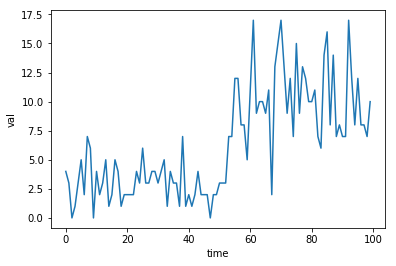

In [223]:
plt.plot(data)
plt.xlabel('time')
plt.ylabel('val')
print("n = {}, lambda1 = {}, lambda2 = {}".format(n,lam1,lam2))

### Joint posterior
To infer the latent variables, we first look to the joint posterior distribution of them.

\begin{equation}
p(\lambda_1, \lambda_2, n | x_{1:N}) \propto
p(x_{1:n} | \lambda_1) p(x_{n+1:N} | \lambda_2) p(\lambda_1)p(\lambda_2)p(n)
\end{equation}

We know exactly how to express the right part of the equation. Gibbs sampling requires conditional posterior distribution of each target variable given all the rest variables, which are $p(\lambda_1|\lambda_2,n,x_{1:N})$, $p(\lambda_2 | \lambda_1, n, x_{1:N})$ and $p(n | \lambda_1, \lambda_2, x_{1:N})$. This could be easily done by selecting terms that are relevant to the subject variables from the joint posterior distrubiton.

In [224]:
######### Gibbs Sampler #########

x = data
# Initialization
n = int(uniform.rvs()*N)
lam1 = gamma.rvs(a,scale=1./b)
lam2 = gamma.rvs(a,scale=1./b)

E=5000

# Store the samples
n_hist = np.zeros(E)
lam1_hist = np.zeros(E)
lam2_hist = np.zeros(E)

for e in range(E):
    # conditional posterior of lam1 & lam2 are Gamma distributed.
    lam1 = gamma.rvs(a+sum(x[0:n]), scale = 1./(n+b))
    lam2 = gamma.rvs(a+sum(x[n:N]), scale = 1./(N-n+b))
    
    # conditional posterior of n are multinomial distributed.
    r = range(N)
    pval = np.exp([-i*lam1 -(N-i)*lam2 + np.log(lam1)*sum(x[:i]) + np.log(lam2)*sum(x[i:N]) for i in r])
    pval = np.exp(pval-max(pval))
    n = np.random.multinomial(1,pval/sum(pval),size=1).nonzero()[1][0]
    
    # store
    n_hist[e]=n
    lam1_hist[e]=lam1
    lam2_hist[e]=lam2


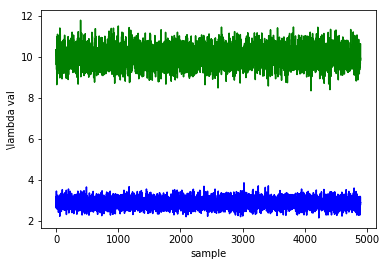

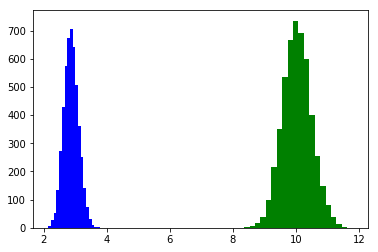

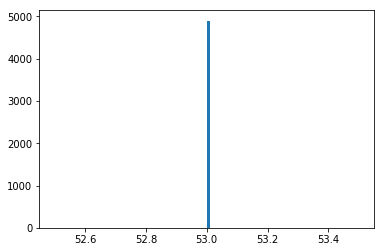

In [225]:
%matplotlib inline
# cut off BURN-IN period
n_hist = n_hist[100:]
lam1_hist = lam1_hist[100:]
lam2_hist = lam2_hist[100:]

# Ploting 
plt.figure(1)
plt.plot(lam1_hist,'b',lam2_hist,'g')
plt.ylabel('\lambda val')
plt.xlabel('sample')

plt.figure(2)
plt.hist(lam1_hist,20,color='b')
plt.hist(lam2_hist,20,color='g')

plt.figure(3)
plt.hist(n_hist,N)

plt.show()

### Expected values
The expected values of latent variables could be found integrating over the posterior distribution:
\begin{equation}
E[\lambda_1 | \lambda_2, n, x_{1:N}] = \int \lambda_1 p(\lambda_1 | \lambda_2, n, x_{1:N}) \quad d\lambda_1
\end{equation}

In [226]:
print("expected value for lam_1 = {}".format(sum(lam1_hist)/len(lam1_hist)))
print("expected value for lam_2 = {}".format(sum(lam2_hist)/len(lam2_hist)))
print("expected value for n = {}".format(sum(n_hist)/len(n_hist)))

expected value for lam_1 = 2.8733514914021416
expected value for lam_2 = 10.03058761580837
expected value for n = 53.0
